In [1]:
import sys
sys.path.append('..')
from utils.pytorch_helper import *
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader

model_type = "mobilenet" # backbone

model = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

checkpoint = torch.load(f"../../models/best_fasterrcnn_{model_type}.pth", weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Model loaded!")

Model loaded!


In [2]:
# Train Dataset
images_dir = "../../data/merged/images/test"
annotations_dir = "../../data/merged/labels/test"
test_dataset = LicensePlateDataset(images_dir, annotations_dir)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [4]:
all_imges = []
all_bboxes = []
for images, targets in test_loader:
    all_imges.extend([img.to(device) for img in images])
    all_bboxes.extend([target["boxes"].cpu().numpy().tolist() for target in targets])
    
evaluator = ObjectDetectionEvaluator(model, all_imges, all_bboxes, fasterrcnn_predict)
evaluator.get_metric_summary(verbose=False)

Processing images: 100%|██████████| 399/399 [00:14<00:00, 27.55it/s]


{'Box(Precision)': 0.7403685090887155,
 'Box(Recall)': 0.8419047617443991,
 'Confusion Matrix': {'TP': 442, 'FP': 155, 'FN': 83, 'TN': None},
 'mAP': [(50, 0.954913854598999),
  (55, 0.9568626284599304),
  (60, 0.9598435163497925),
  (65, 0.9549413919448853),
  (70, 0.9534488320350647),
  (75, 0.9256165027618408),
  (80, 0.8638023138046265),
  (85, 0.7088753581047058),
  (90, 0.40709397196769714),
  (95, 0.06338842213153839)],
 'mAP50': 0.954913854598999,
 'mAP50-95': np.float64(0.774878679215908)}

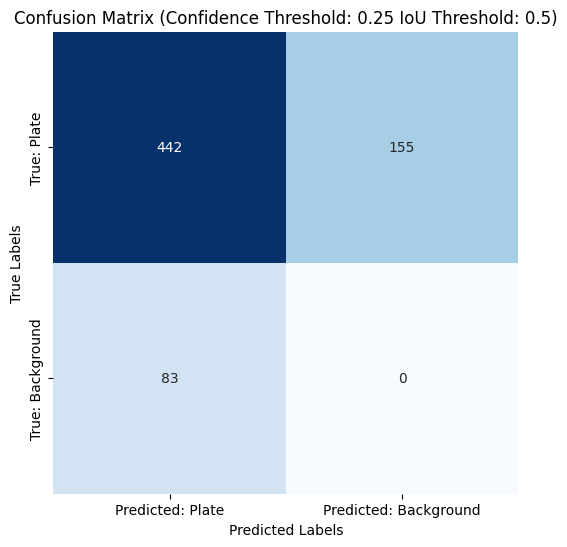

In [5]:
evaluator.visualize_confusion_matrix()

Precision calculation not possible at confidence ge: 1.0


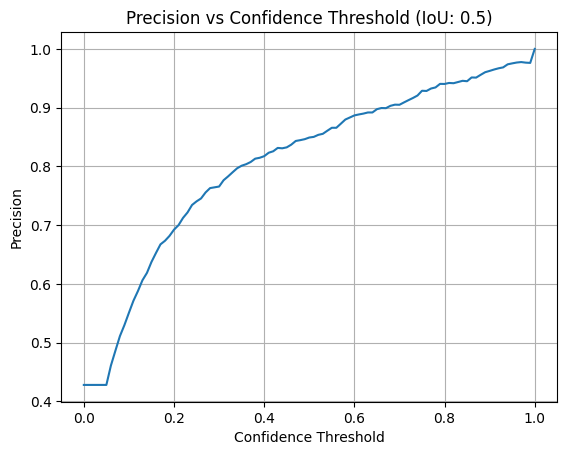

In [10]:
evaluator.visualize_precision_confidence_curve()

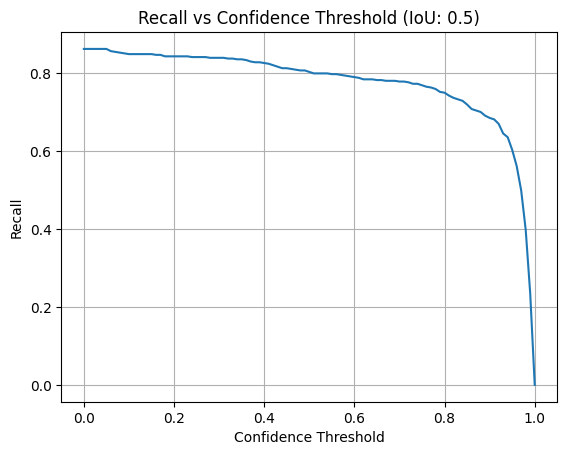

In [11]:
evaluator.visualize_recall_confidence_curve()

Precision calculation not possible at confidence ge: 1.0


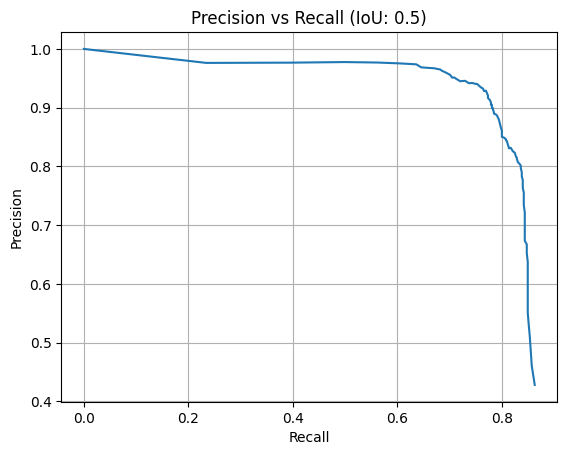

In [12]:
evaluator.visualize_precision_recall_curve()

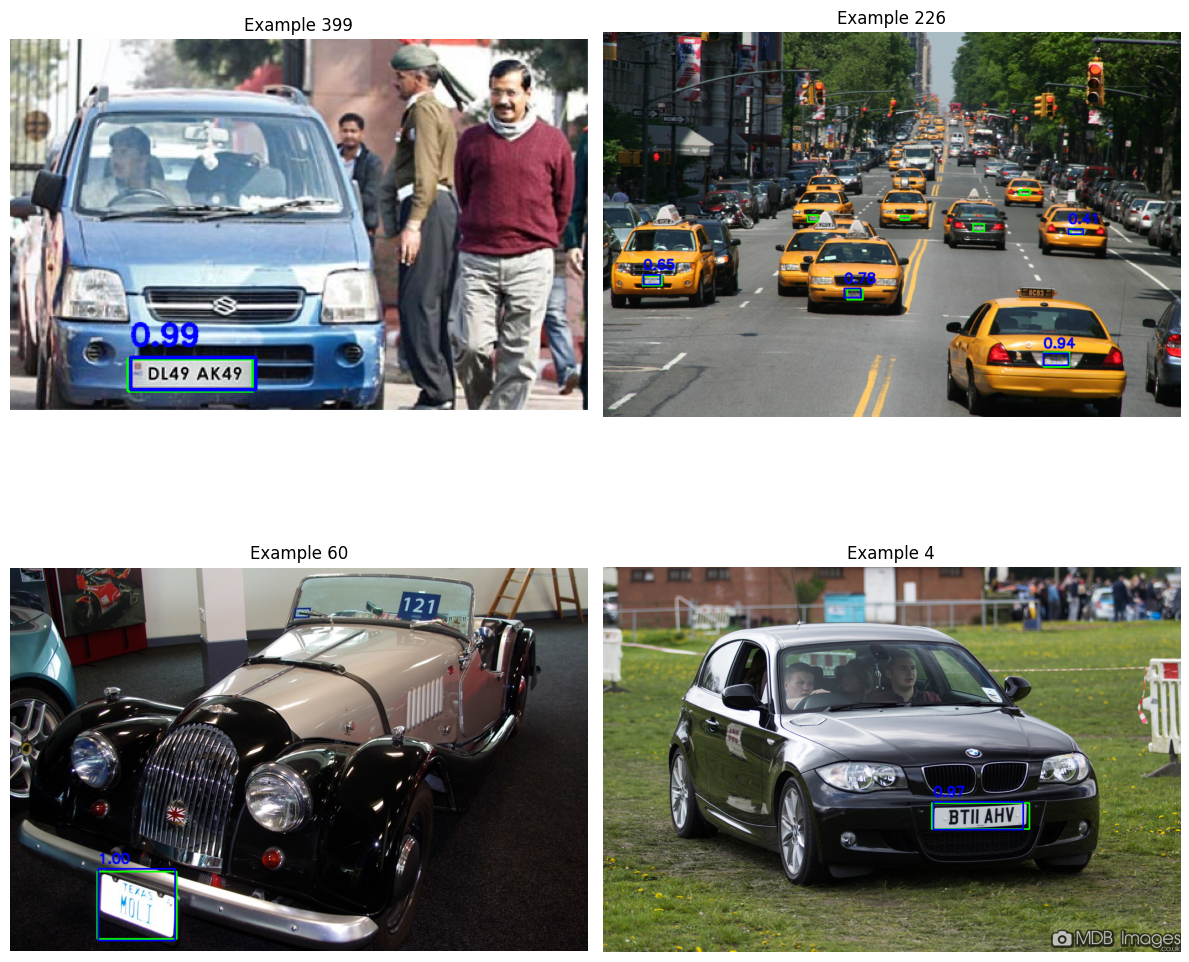

In [13]:
evaluator.visualize_for_examples()

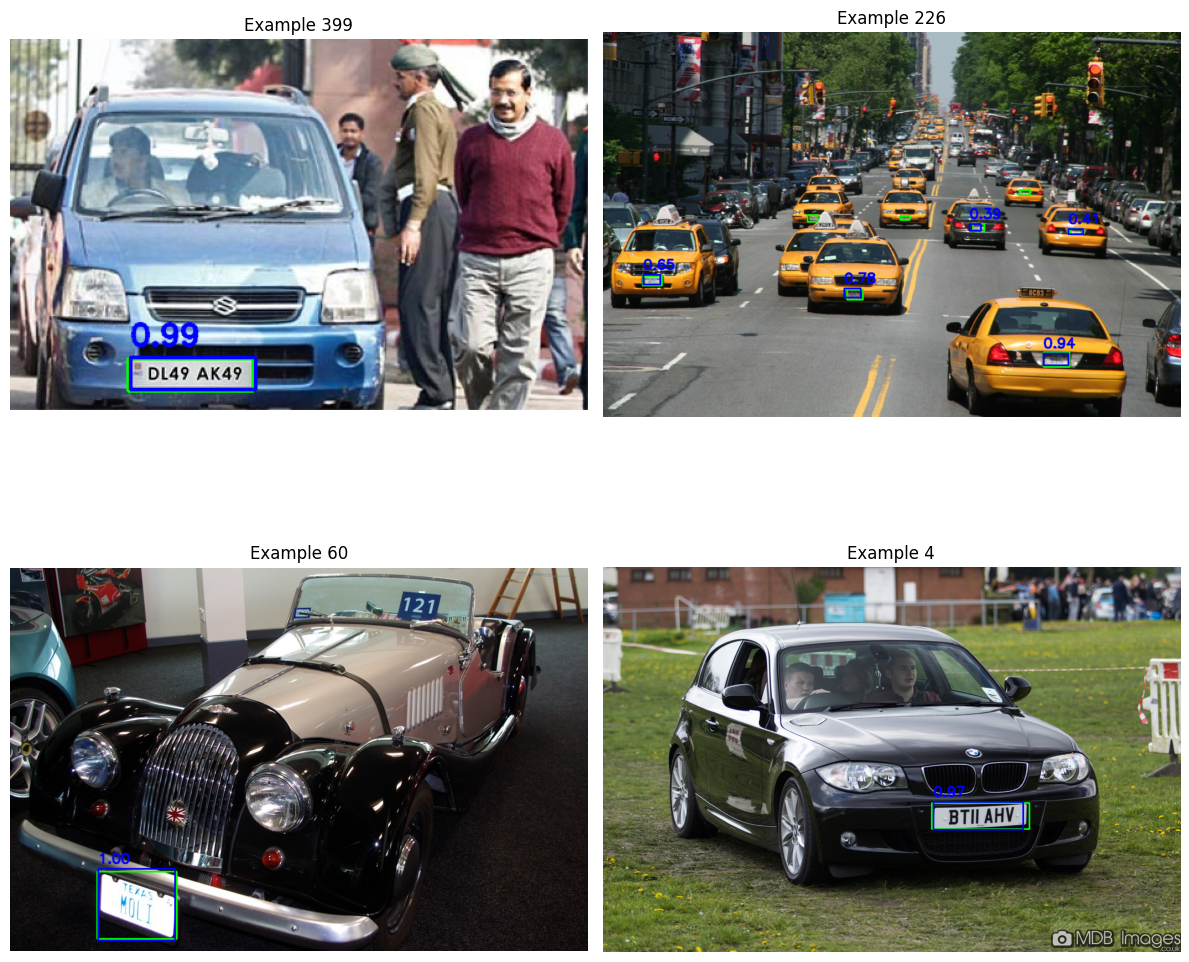

In [16]:
evaluator.visualize_for_examples(conf_threshold=0.01, iou_threshold=0.5)

In [16]:
@torch.inference_mode()
def fasterrcnn_predict(model, img, confidence = 0.001, **kwargs):
    model.eval()
    if not isinstance(img, torch.Tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transforms.ToTensor()(img).to(device)
        
    if not isinstance(img, list):
        img = [img]

    with torch.inference_mode():
        outputs = model(img)

    confidences = []
    boxes = []
    
    for output in outputs:
        if "scores" in output and "boxes" in output:
            scores = output["scores"].cpu().numpy()
            bboxes = output["boxes"].cpu().numpy()
            
            valid_indices = scores > confidence
            scores = scores[valid_indices]
            bboxes = bboxes[valid_indices]
    
            confidences.extend(scores.tolist())
            boxes.extend(bboxes.tolist())
    
    return confidences, boxes


In [17]:
evaluator.predict_function = fasterrcnn_predict

In [19]:
from deep_sort_realtime.deepsort_tracker import DeepSort
deepsort = DeepSort(max_iou_distance=0.99, max_age=10)
evaluator.generate_evaluation_video(deepsort, "../../data/Traffic_Video.mp4", "../../data/Output_Mobilenet.mp4", 0.5)

Average Processing Time per Frame: 0.2077877880540165
Average Number of Different Plate Prediction per Tracking Target: 20.54901960784314
